<a href="https://colab.research.google.com/github/IshanaySharma/Machine_learning_projects/blob/main/Credit_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import plot_precision_recall_curve
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report
from lightgbm import LGBMClassifier

In [3]:
df = pd.read_csv('/content/credit_risk_dataset.csv')
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [4]:
df.shape

(32581, 12)

In [5]:
dups = df.duplicated() #Checking for duplicate entries
df[dups]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
15975,23,42000,RENT,5.0,VENTURE,B,6000,9.99,0,0.14,N,4
15989,23,90000,MORTGAGE,7.0,EDUCATION,B,8000,10.36,0,0.09,N,3
15995,24,48000,MORTGAGE,4.0,MEDICAL,A,4000,5.42,0,0.08,N,4
16025,24,10000,RENT,8.0,PERSONAL,A,3000,7.90,1,0.30,N,3
16028,23,100000,MORTGAGE,7.0,EDUCATION,A,15000,7.88,0,0.15,N,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32010,42,39996,MORTGAGE,2.0,HOMEIMPROVEMENT,A,2500,5.42,0,0.06,N,12
32047,36,250000,RENT,2.0,DEBTCONSOLIDATION,A,20000,7.88,0,0.08,N,17
32172,49,120000,MORTGAGE,12.0,MEDICAL,B,12000,10.99,0,0.10,N,12
32259,39,40000,OWN,4.0,VENTURE,B,1000,10.37,0,0.03,N,16


In [12]:
df.drop_duplicates(inplace=True)
df.shape

(32416, 12)

In [19]:
#Segregarting into training and testing data
X, X_test, y, y_test = train_test_split(df.drop('loan_status', axis=1), df['loan_status'],
                                        random_state=0,  test_size=0.2, stratify=df['loan_status'],
                                        shuffle=True)
df['loan_status'].value_counts(normalize=True)

0    0.781312
1    0.218688
Name: loan_status, dtype: float64

In [8]:
y.value_counts(normalize=True)

0    0.781313
1    0.218687
Name: loan_status, dtype: float64

In [9]:
y_test.value_counts(normalize=True)

0    0.781308
1    0.218692
Name: loan_status, dtype: float64

In [10]:
np.round(X.isna().sum()* 100 / X.shape[0], 3) #Checking for no.of missing values 

person_age                    0.000
person_income                 0.000
person_home_ownership         0.000
person_emp_length             2.800
loan_intent                   0.000
loan_grade                    0.000
loan_amnt                     0.000
loan_int_rate                 9.614
loan_percent_income           0.000
cb_person_default_on_file     0.000
cb_person_cred_hist_length    0.000
dtype: float64

In [20]:
X[['person_income', 'loan_amnt', 'loan_percent_income']].head()

,person_income,loan_amnt,loan_percent_income
21415,48000,10000,0.21
12916,85000,7500,0.09
2938,125000,3000,0.02
19114,62000,2300,0.04
6057,48000,4200,0.09


In [21]:
# loan_percent income not adding anything to our dataset so we will drop it
X.drop('loan_percent_income', axis=1, inplace=True)
X_test.drop('loan_percent_income', axis=1, inplace=True)

In [22]:
#Checking unique values in each column
for col in X:
    print(col, '--->', X[col].nunique())
    if X[col].nunique()<20:
        print(X[col].value_counts(normalize=True)*100)
    print()

person_age ---> 58

person_income ---> 3680

person_home_ownership ---> 4
RENT        50.320068
MORTGAGE    41.439149
OWN          7.916859
OTHER        0.323924
Name: person_home_ownership, dtype: float64

person_emp_length ---> 36

loan_intent ---> 6
EDUCATION            19.809502
MEDICAL              18.787598
VENTURE              17.542033
PERSONAL             16.878760
DEBTCONSOLIDATION    15.968687
HOMEIMPROVEMENT      11.013420
Name: loan_intent, dtype: float64

loan_grade ---> 7
A    32.932284
B    32.126330
C    19.902052
D    11.121394
E     3.004010
F     0.732685
G     0.181243
Name: loan_grade, dtype: float64

loan_amnt ---> 710

loan_int_rate ---> 346

cb_person_default_on_file ---> 2
N    82.392411
Y    17.607589
Name: cb_person_default_on_file, dtype: float64

cb_person_cred_hist_length ---> 29



In [23]:
X.describe

<bound method NDFrame.describe of        person_age  ...  cb_person_cred_hist_length
21415          33  ...                           8
12916          25  ...                           3
2938           26  ...                           4
19114          29  ...                           6
6057           24  ...                           4
...           ...  ...                         ...
23921          29  ...                           8
27783          29  ...                           7
24358          27  ...                           9
2544           23  ...                           3
6848           24  ...                           3

[25932 rows x 10 columns]>

In [26]:
num_cols = [col for col in X if X[col].dtypes != 'O']
num_cols # Checking all the numerical columns

['person_age',
 'person_income',
 'person_emp_length',
 'loan_amnt',
 'loan_int_rate',
 'cb_person_cred_hist_length']

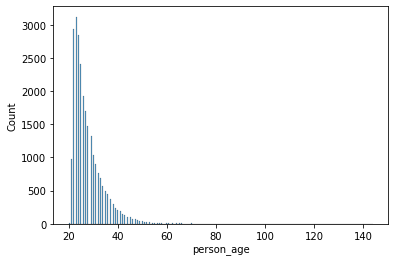

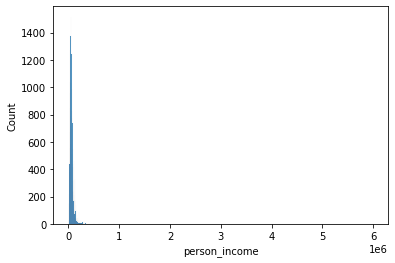

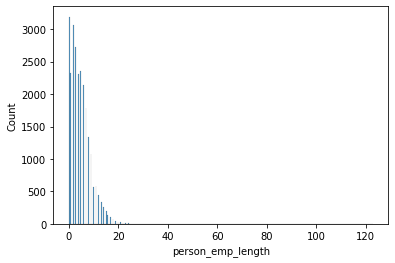

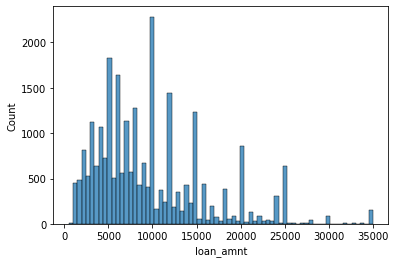

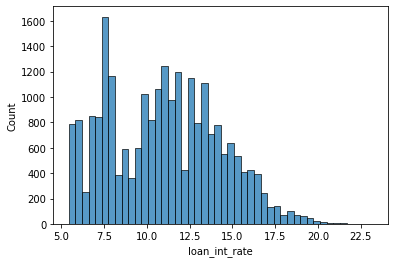

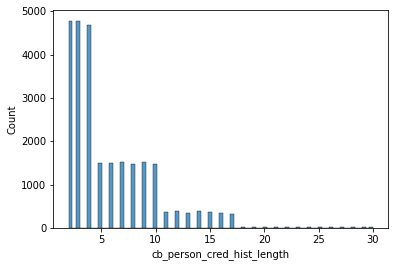

In [29]:
import seaborn as sns
for col in num_cols:
    sns.histplot(X[col])
    plt.show() #plotting the numerical columns

In [30]:
X.loc[X['person_age']>=80, :] #Checking if anyone above 80 is applying for a loan cause it is less likely

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,cb_person_default_on_file,cb_person_cred_hist_length
32422,80,64000,RENT,7.0,MEDICAL,B,6800,11.71,N,25
81,144,250000,RENT,4.0,VENTURE,C,4800,13.57,N,3
32416,94,24000,RENT,1.0,MEDICAL,C,6500,NaN,N,27
747,123,78000,RENT,7.0,VENTURE,B,20000,NaN,N,4
183,144,200000,MORTGAGE,4.0,EDUCATION,B,6000,11.86,N,2
575,123,80004,RENT,2.0,EDUCATION,B,20400,10.25,N,3
32506,84,94800,MORTGAGE,2.0,PERSONAL,A,10000,7.51,N,24
32297,144,6000000,MORTGAGE,12.0,PERSONAL,C,5000,12.73,N,25


In [32]:
X = X.loc[X['person_age']<80, :]
X.shape

(25924, 10)

In [33]:
X.loc[X['person_emp_length']>=66, :] #Since min working age is 14, checking and getting rid of employment length > 66yrs

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,cb_person_default_on_file,cb_person_cred_hist_length
210,21,192000,MORTGAGE,123.0,VENTURE,A,20000,6.54,N,4
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,Y,3


In [34]:
df.query("person_age<=person_emp_length+14")

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
210,21,192000,MORTGAGE,123.0,VENTURE,A,20000,6.54,0,0.10,N,4


In [35]:
X = X.loc[(X['person_emp_length']<66) | (X['person_emp_length'].isna()), :]
# since we've removed some data from X, we need to pass on these updations to y as well,
# as y doesn't know some of its corresponding X's have been deleted.
y = y[X.index]

In [36]:
cat_cols = [col for col in X if X[col].dtypes == 'O']
cat_cols

['person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file']

In [39]:
num_pipe = Pipeline([
    ('impute', IterativeImputer()), #imputing missing values
    ('scale', StandardScaler()), #scaling the columns
])

In [40]:
ct = ColumnTransformer([
    ('num_pipe', num_pipe, num_cols),
    ('cat_cols', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_cols)
], remainder='passthrough')

In [41]:
#creating a grid and separating into keys and values
grid = {
    RandomForestClassifier(random_state=0, n_jobs=-1, class_weight='balanced'):
    {'model__n_estimators':[300,400,500],
     'coltf__num_pipe__impute__estimator': [LinearRegression(), RandomForestRegressor(random_state=0),
                                        KNeighborsRegressor()]},
    
    LGBMClassifier(class_weight='balanced', random_state=0, n_jobs=-1):
    {'model__n_estimators':[300,400,500],
     'model__learning_rate':[0.001,0.01,0.1,1,10],
     'model__boosting_type': ['gbdt', 'goss', 'dart'],
     'coltf__num_pipe__impute__estimator':[LinearRegression(), RandomForestRegressor(random_state=0),
                                        KNeighborsRegressor()]},
}

In [42]:
for clf, param in grid.items():
    print(clf)
    print('-'*50)
    print(param)
    print('\n')

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=0)
--------------------------------------------------
{'model__n_estimators': [300, 400, 500], 'coltf__num_pipe__impute__estimator': [LinearRegression(), RandomForestRegressor(random_state=0), KNeighborsRegressor()]}


LGBMClassifier(class_weight='balanced', random_state=0)
--------------------------------------------------
{'model__n_estimators': [300, 400, 500], 'model__learning_rate': [0.001, 0.01, 0.1, 1, 10], 'model__boosting_type': ['gbdt', 'goss', 'dart'], 'coltf__num_pipe__impute__estimator': [LinearRegression(), RandomForestRegressor(random_state=0), KNeighborsRegressor()]}




In [ ]:
#defining 2 empty containers i.e. dataframe and a dictionary
full_df = pd.DataFrame()
best_algos = {}

for clf, param in grid.items():
    pipe = Pipeline([
    ('coltf', ct),
    ('model', clf)
])

    gs = RandomizedSearchCV(estimator=pipe, param_distributions=param, scoring='accuracy',
                            n_jobs=-1, verbose=3, n_iter=4)  #random permutation selection and creation of the model
    
    gs.fit(X, y) #fitting the model
    
    all_res = pd.DataFrame(gs.cv_results_)

    temp = all_res.loc[:, ['params', 'mean_test_score']]
    algo_name = str(clf).split('(')[0]
    temp['algo'] = algo_name
    
    full_df = pd.concat([full_df, temp])
    best_algos[algo_name] = gs.best_estimator_

In [ ]:
full_df.sort_values('mean_test_score', ascending=False) # sorting models by best accuracy

In [ ]:
full_df.sort_values('mean_test_score', ascending=False).iloc[0, 0]
{'model__n_estimators': 400,
 'coltf__num_pipe__impute__estimator': RandomForestRegressor(random_state=0)}

In [ ]:
be = best_algos['RandomForestClassifier']
print(be)

In [ ]:
be.fit(X, y)

In [ ]:
preds = be.predict(X_test)

In [ ]:
confusion_matrix(y_test, preds)

In [ ]:
plot_confusion_matrix(be, X_test, y_test)

In [ ]:
print(classification_report(y_test, preds))

In [ ]:
be.score(X_test, y_test)

In [ ]:
plot_precision_recall_curve(estimator=be, X=X_test, y=y_test, name='model AUC')
baseline = y_test.sum() / len(y_test)
plt.axhline(baseline, ls='--', color='r', label=f'Baseline model ({round(baseline,2)})')
plt.legend(loc='best')

In [ ]:
a, b, c = learning_curve(be, X, y, n_jobs=-1, scoring='accuracy')

In [ ]:
plt.plot(a, b.mean(axis=1), label='training accuracy')
plt.plot(a, c.mean(axis=1),  label='validation accuracy')
plt.xlabel('training sample sizes')
plt.ylabel('accuracy')
plt.legend()